In [1]:
!pip install PyWavelets --quiet

In [2]:
import pandas as pd
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
import pywt
import scipy.signal as signal
from collections import Counter

In [3]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.feature_selection import SelectKBest, f_regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import math

## Fourier Transformation

Decomposing a time-series (aka a signal in time-domain) by Fourier transform, we can study the periodicity of the signal. As a matter of fact, this technique is based on the decomposition of the signal in its periodic components, which will be the inputs to construct the corresponding signal in the frequency domain.
After applying a Fourier transform on a signal we will obtain information about the component frequencies of the signal.

The aim of applying Fourier transform is to decompose the original signal into a sum of its simpler signals (aka trigonometric functions sine and cosine), no matter how complex the original one is. 

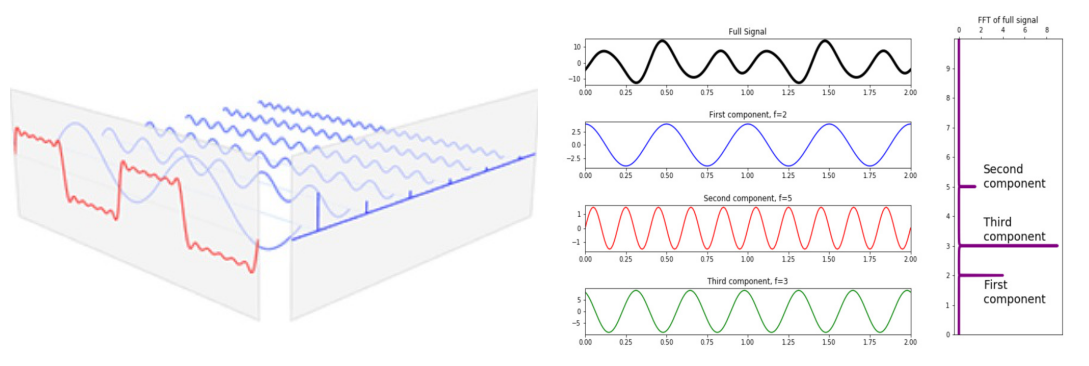

In [5]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('ft_vis.jpeg')
img_B = mpimg.imread('ft_vis2.jpeg')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[0].axis('off')
ax[1].imshow(img_B)
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
start = time.time()
train_df = pd.read_csv('train.csv')
end = time.time()
print("Read train csv: ",(end-start),"sec")

Read train csv:  40.35992670059204 sec


In [7]:
train_df.shape

(663, 49157)

In [8]:
start = time.time()
test_df = pd.read_csv('test.csv')
end = time.time()
print("Read test csv: ",(end-start),"sec")

Read test csv:  22.19005537033081 sec


In [9]:
def names_to_numeric(df):
    main_list = df['main.pos'].unique()
    fun_list = df['fun.pos'].unique()
    when_list = df['when'].unique()
    
    f = dict(zip(fun_list,range(len(fun_list))))
    m = dict(zip(main_list,range(len(main_list))))
    w = dict(zip(when_list,range(len(when_list))))

    df['fun.pos'] = df['fun.pos'].apply(lambda x: f[x] )
    df['main.pos'] = df['main.pos'].apply(lambda x: m[x] )
    df['when'] = df['when'].apply(lambda x: w[x] )
    
    return df

def convert_df(df, idx):
    start = time.time()
    measure_point_name = sorted(list(set([name[:3] for name in list(df.columns)[idx:]])))

    # instants label ROIs-wise
    point_time_series = [[instant for instant in list(df.columns)[idx:] if (point == instant[:3])] for point in measure_point_name]

    observations = list()
    for i in range(df.shape[0]):
        observations.append(pd.DataFrame(np.transpose(np.reshape(df.iloc[i,idx:].values, (24,2048))), columns = measure_point_name))
    end = time.time()
    print("Convert df: ",(end-start),"sec")
    return observations

In [10]:
pre_obs_train = convert_df(train_df, 5)
pre_obs_test = convert_df(test_df, 4)

Convert df:  19.26021432876587 sec
Convert df:  10.219696283340454 sec


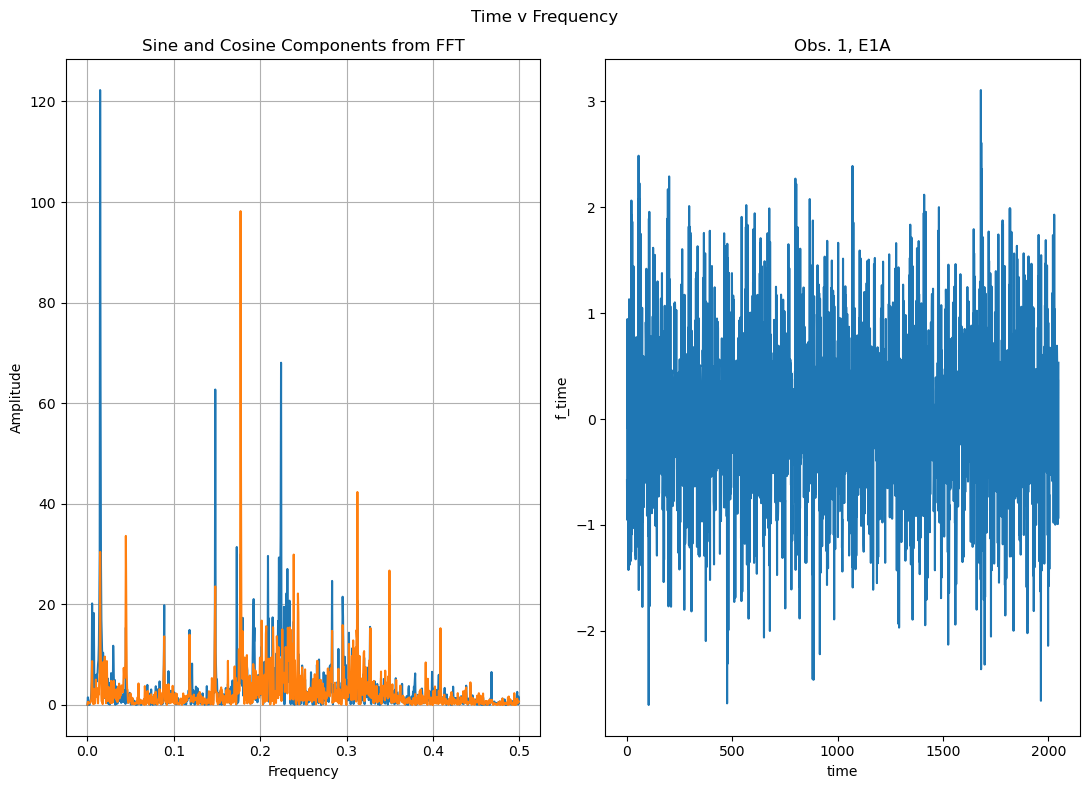

In [11]:
fft_values = np.fft.fft(pre_obs_train[0]['M2V'])
frequencies = np.fft.fftfreq(len(pre_obs_train[0]['M2V']))

# Find the indices corresponding to the positive frequencies
positive_indices = np.where(frequencies >= 0)

# Extract the sine and cosine components
sine_component = 2 * np.abs(fft_values[positive_indices].imag)
cosine_component = 2 * np.abs(fft_values[positive_indices].real)

# Plot the sine and cosine components
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Time v Frequency')

ax1.plot(frequencies[positive_indices], sine_component, label='Sine Component')
ax1.plot(frequencies[positive_indices], cosine_component, label='Cosine Component')
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Amplitude')
ax1.set_title('Sine and Cosine Components from FFT')
ax1.grid(True)

ax2.plot(range(1, 2049) , pre_obs_train[0]['E1A'])
ax2.set_xlabel('time')
ax2.set_ylabel('f_time')
ax2.set_title('Obs. 1, E1A')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figures side by side
plt.show()

Fourier transform works very well for stationary signals, when no variation in time happens, but in the frequency-domain we lose this dependency. We can consider the Fourier transform as a trade-off between time information and frequency information. By taking a FT of a time signal, all time information is lost in return for frequency information.

This means that the FT may fail in breaking down the signal clearly, if it is full of frequencies that vary on time. For example, when we have an abrupt change in the behaviour of the signal, such as a malfunctioning of the compressor, or its failure.

## Wavelet Decomposition

Wavelet Transform offers better time-frequency localization compared to Fourier Transform. It can capture localized changes in the signal's characteristics over time, making it suitable for analyzing non-stationary signals with varying frequencies.
Moreover, the wavelet decomposition provides a multiresolution representation of the signal, allowing the analysis at different scales or levels of detail. This is particularly useful since we want to capture both high-frequency and low-frequency components simultaneously, to focus on the latter.

If the compressor measurements contain transient events or abrupt changes, wavelet decomposition can help identify and analyze these localized features effectively.
In particular, since it seems that low frequencies captures better the anomalies in the compressors' behaviour, we have focused on extracting the information related to them, which are transformed and collected in the first output of the pywt.wavedec method from pywt library - the one who chose to implement wavelet transform. This function returns a tuple of lists, containing the coefficients calculated from the time series. The first list is the aprroximated coefficients list - related to the lower frequencies - while the other lists (number dependent on the level of decomposition) contain the higher frequencies related coefficients. As seen in the code, we will extract and summarize out signals by the coeffs[0], the lower frequencies coefficients.

In [12]:
def ttw_series(time_data, wavelet, level):
    # Perform the wavelet decomposition
    coeffs = pywt.wavedec(time_data, wavelet, level=level)
    return coeffs[0]


def ttw_df(time_df, wavelet, level):
    wavelet_df = time_df.apply(ttw_series, args=([wavelet, level]), axis=0)
    return wavelet_df


def time_to_wavelets(dfs):
    wavelet = 'coif4' 
    level = pywt.dwt_max_level(dfs[0].shape[0], pywt.Wavelet(wavelet))  
    
    wavelet_decs = list()
    for df in dfs:
        signal = ttw_df(df, wavelet, level)
        wavelet_decs.append(signal)
    return wavelet_decs


In [13]:
pre_wave_train = time_to_wavelets(pre_obs_train)
pre_wave_test = time_to_wavelets(pre_obs_test)

In [14]:
pre_wave_train[0].shape

(54, 24)

In [15]:
def reshaped(waves):
    reshaped_dfs = list()
    for df in waves:
        reshaped_dfs.append(pd.DataFrame(df.values.flatten(order='F')).T)
    return reshaped_dfs

In [16]:
pre_reshaped_train = reshaped(pre_wave_train)
pre_reshaped_test = reshaped(pre_wave_test)

In [17]:
pre_joined_train = pd.concat(pre_reshaped_train, axis=0, ignore_index=True)
pre_joined_test = pd.concat(pre_reshaped_test, axis=0, ignore_index=True)

train_df_num = names_to_numeric(train_df.iloc[:, 0:5])
X_train = pd.concat([train_df_num, pre_joined_train], axis=1).drop(['y', 'id'], axis=1)
Y_train = train_df_num[['y']]

In [18]:
test_df_num = names_to_numeric(test_df.iloc[:, 0:4])
X_test = pd.concat([test_df_num, pre_joined_test], axis=1).drop(['id'], axis=1)

for d in [X_train, Y_train, X_test]:
    d.columns = d.columns.astype(str)

In [19]:
X_train.shape

(663, 1299)

In [20]:
X_train.to_csv('wave_Xtrain.csv', index=False)

### PCA

#### Linear PCA

In [21]:
# get a pca object
pca = PCA(n_components=200)  
# pca on scaled df
pca_train = pca.fit_transform(X_train)

X_train_pca = pd.DataFrame(pca_train)

In [22]:
# on test
pca = PCA(n_components=200)  
pca_test = pca.fit_transform(X_test)

X_test_pca = pd.DataFrame(pca_test)

#### Kernel PCA

In [23]:
kpca = KernelPCA(kernel='rbf')
kpca_train = kpca.fit_transform(X_train)

X_train_kpca = pd.DataFrame(kpca_train)

In [24]:
# on test
kpca = KernelPCA(kernel='rbf')  
kpca_test = kpca.fit_transform(X_test)

X_test_kpca = pd.DataFrame(kpca_test)

### TUNING PARAMETERS

#### SVM

In [25]:
param_grid = {
    'C': [ 0.1, 0.5, 1, 10, 30, 50],
    'kernel': ['linear', 'rbf', 'sigmoid','poly'],
    'gamma': [0.1, 0.01, 0.5, 'scale']
}

# Calculate class weights
class_weights = dict()
unique_classes = set(Y_train['y'])

for cls_ in unique_classes:
    class_weights[cls_] = len(Y_train['y']) / (len(unique_classes) * np.bincount(Y_train['y'])[cls_])
    
# Create the SVM classifier
svm = SVC(class_weight= class_weights,random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring = "balanced_accuracy")
grid_search.fit(X_train_pca, Y_train['y'])
#grid_search.fit(X_train_kpca, Y_train['y'])

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
Best Score: 0.4939480236370626


In [26]:
def CI(df): 
    split=10
    z=2.58  #--> this for 99% (z=1.96 --> for 95%)
    CI_inf=[]
    CI_sup=[]
    for i in range(df.shape[0]):
        mean_i=df.loc[i, 'mean_test_score']
        std_i=df.loc[i, 'std_test_score']
        
        CI_inf.append(round(mean_i-z*(std_i/math.sqrt(split)),3) )
        CI_sup.append(round(mean_i+z*(std_i/math.sqrt(split)),3))
    
    df.insert(1,'CI_inf',CI_inf)
    df.insert(2,'CI_sup',CI_sup)
    return( df )

In [27]:
CV_results_SVM = grid_search.cv_results_
CV_result = pd.DataFrame(CV_results_SVM)
CV_result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [28]:
synthetic_svm = CI(CV_result)[['params', 'CI_inf', 'CI_sup', 'mean_test_score', 'std_test_score', 'rank_test_score']]
synthetic_svm.sort_values('CI_inf', ascending=False).head() #pessimistic approach

,params,CI_inf,CI_sup,mean_test_score,std_test_score,rank_test_score
95,"{'C': 50, 'gamma': 'scale', 'kernel': 'poly'}",0.364,0.624,0.493948,0.159605,1
93,"{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}",0.356,0.396,0.375957,0.024674,22
77,"{'C': 30, 'gamma': 'scale', 'kernel': 'rbf'}",0.351,0.393,0.372192,0.026046,23
79,"{'C': 30, 'gamma': 'scale', 'kernel': 'poly'}",0.350,0.616,0.482715,0.163131,2
61,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.348,0.395,0.371614,0.028819,24


In [29]:
synthetic_svm.sort_values('CI_sup', ascending=False).head() #optimistic

,params,CI_inf,CI_sup,mean_test_score,std_test_score,rank_test_score
95,"{'C': 50, 'gamma': 'scale', 'kernel': 'poly'}",0.364,0.624,0.493948,0.159605,1
63,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.338,0.621,0.479538,0.173268,3
79,"{'C': 30, 'gamma': 'scale', 'kernel': 'poly'}",0.350,0.616,0.482715,0.163131,2
51,"{'C': 10, 'gamma': 0.1, 'kernel': 'poly'}",0.324,0.592,0.458147,0.164646,4
39,"{'C': 1, 'gamma': 0.01, 'kernel': 'poly'}",0.324,0.592,0.458147,0.164646,4


In [30]:
#PESSIMISTIC SUBMISSION
model = SVC(C=50, gamma='scale' , kernel='poly')
model.fit(X_train_pca, Y_train['y'])
Y_pred_pess = model.predict(X_test_pca)
pessimistic_solution = pd.DataFrame({'id': test_df['id'], 'y': Y_pred_pess})

In [31]:
#OPTIMISTIC SUBMISSION
model = SVC(C=10, gamma='scale', kernel='poly')
model.fit(X_train_pca, Y_train['y'])
Y_pred_opt = model.predict(X_test_pca)
optimistic_solution = pd.DataFrame({'id': test_df['id'], 'y': Y_pred_opt})

In [32]:
print(Counter(pessimistic_solution['y']))
print(Counter(optimistic_solution['y']))

Counter({1: 347, 2: 5, 3: 3})
Counter({1: 353, 2: 1, 3: 1})


In [33]:
pessimistic_solution.to_csv('SOL_8.csv',index=False)
optimistic_solution.to_csv('SOL_9.csv',index=False)